## Ambil data

In [1]:
!pip install -U -q PyDrive
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# choose a local (colab) directory to store the data.
local_download_path = os.path.expanduser('~/data')
try:
  os.makedirs(local_download_path)
except: pass

# 2. Auto-iterate using the query syntax
#    https://developers.google.com/drive/v2/web/search-parameters
file_list = drive.ListFile(
    {'q': "'15wHhiqeNfFW1OzrFI0LdgLnE9o28UzAC' in parents"}).GetList()

for f in file_list:
  # 3. Create & download by id.
  print('title: %s, id: %s' % (f['title'], f['id']))
  fname = os.path.join(local_download_path, f['title'])
  print('downloading to {}'.format(fname))
  f_ = drive.CreateFile({'id': f['id']})
  f_.GetContentFile(fname)

title: train2.csv, id: 1WmX7WOkgLXc8bMAD7sxSCWxCeI7kPYB5
downloading to /content/data/train2.csv
title: test2.csv, id: 1M6i3x201aQFY1WrDER1cOAzcVk5G_7Vv
downloading to /content/data/test2.csv
title: train.csv, id: 1h6Xc_xZRMeTce4ZfLan_wJGTMfPK0Rq4
downloading to /content/data/train.csv
title: test.csv, id: 17QQlwUBmrX5VK2mRFK6aZ9XMN9NHCuJD
downloading to /content/data/test.csv
title: sample_submission.csv, id: 19C-53P--hLGtqSx0DMACT9LWj4XxsjsY
downloading to /content/data/sample_submission.csv


# Eksplorasi Data

## Import

In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

In [0]:
data_train = pd.read_csv('/content/data/train.csv')
data_test = pd.read_csv('/content/data/test.csv')

## Summary

---

Dataset yang digunakan merupakan data Sensus Ekonomi
Tahun
2006 
dari 
Propinsi Bengkulu, Kabupaten Kapahiang yang dilakukan oleh Badan Pusat Statistik.
Dataset tersebut berisi data
-
data dari badan usaha yang berada di Kabupaten 
Kapahiang beserta beberapa fakta mengenai badan usaha yang bersangkutan. Fakta
-
fakta yang terkandung 
tersebut akan dibahas pada Penjelasan Kolom Dataset

### Kolom

---

1. prop = Propinsi tempat usaha
2. kab = Kabupaten tempat usaha
3. iduniq = Unique ID
4. b4k6 = Jenis usaha (1-4)
5. b4k71 = Bidang usaha (A-X)
6. b4k81 = Jam buka
7. b4k82 = Menit buka
8. b4k91 = Jam tutup
9. b4k92 = Menit tutup
10. b4k10 = Jumlah tenaga kerja laki - laki
11. b4k11 = Jumlah tenaga kerja perempuan
12. b4k12 = Jumlah total tenaga kerja
13. b4k13 = Aset tahun lalu
14. b4k16 = Omset usaha per bulan (TARGET)
15. b4k17 = Lama usaha dalam bulan

In [0]:
target = 'b4k16'

In [5]:
data_train.columns

Index(['prop', 'kab', 'iduniq', 'b4k6', 'b4k71', 'b4k81', 'b4k82', 'b4k91',
       'b4k92', 'b4k10', 'b4k11', 'b4k12', 'b4k13', 'b4k16', 'b4k17'],
      dtype='object')

### Head

In [6]:
data_train.head()

,prop,kab,iduniq,b4k6,b4k71,b4k81,b4k82,b4k91,b4k92,b4k10,b4k11,b4k12,b4k13,b4k16,b4k17
0,17,8,845,2,H,7,0,12,0,0,1,1,1500000,900000,10
1,17,8,1535,2,H,7,0,12,0,0,1,1,1800000,750000,10
2,17,8,448,2,G,7,0,17,0,0,1,1,2500000,1500000,12
3,17,8,4152,2,G,8,0,16,0,0,1,1,150000,450000,12
4,17,8,73,2,G,8,0,20,0,1,0,1,500000,330000,4


Bedasarkan penjelasan dataset, dataset yang digunakan adalah Sensus Ekonomi Tahun 2006 dari Propinsi Bengkulu, Kabupaten Kapahiang. Sehingga kolom prop dan kab tidak dibutuhkan, karena nilainya pasti semua sama.

In [7]:
# Drop kolom prop dan kab
data_train = data_train.drop(['prop', 'kab'], axis = 1)
data_test = data_test.drop(['prop', 'kab'], axis = 1)
data_train.head()

,iduniq,b4k6,b4k71,b4k81,b4k82,b4k91,b4k92,b4k10,b4k11,b4k12,b4k13,b4k16,b4k17
0,845,2,H,7,0,12,0,0,1,1,1500000,900000,10
1,1535,2,H,7,0,12,0,0,1,1,1800000,750000,10
2,448,2,G,7,0,17,0,0,1,1,2500000,1500000,12
3,4152,2,G,8,0,16,0,0,1,1,150000,450000,12
4,73,2,G,8,0,20,0,1,0,1,500000,330000,4


Kolom jam dan menit terpisah, padahal waktu itu merupakan satu kategori, 9.30 tentu saja beda dengan 18.30, walaupun menitnya sama-sama 30.

Kita akan menggabungkan kolom jam dan menit, menjadi kolom menit saja (dimulai dari 00.00). Kemudian membuat kolom baru yaitu kolom lama tempat usaha buka, dengan asumsi awal bahwa lama buka biasanya mempengaruhi pendapatan (untuk beberapa jenis usaha, contohnya usaha jual beli).

In [8]:
# Menggabungkan kolom jam dan menit (buka dan tutup), dan menambah kolom durasi
data_train['buka'] = data_train['b4k81'] * 60 + data_train['b4k82']
data_train['tutup'] = data_train['b4k91'] * 60 + data_train['b4k92']
data_train = data_train.drop(['b4k81', 'b4k82', 'b4k91', 'b4k92'], axis = 1)
data_train['durasi'] = data_train['tutup'] - data_train['buka']
data_train.head()

,iduniq,b4k6,b4k71,b4k10,b4k11,b4k12,b4k13,b4k16,b4k17,buka,tutup,durasi
0,845,2,H,0,1,1,1500000,900000,10,420,720,300
1,1535,2,H,0,1,1,1800000,750000,10,420,720,300
2,448,2,G,0,1,1,2500000,1500000,12,420,1020,600
3,4152,2,G,0,1,1,150000,450000,12,480,960,480
4,73,2,G,1,0,1,500000,330000,4,480,1200,720


In [9]:
# Menggabungkan kolom jam dan menit (buka dan tutup), dan menambah kolom durasi
data_test['buka'] = data_test['b4k81'] * 60 + data_test['b4k82']
data_test['tutup'] = data_test['b4k91'] * 60 + data_test['b4k92']
data_test = data_test.drop(['b4k81', 'b4k82', 'b4k91', 'b4k92'], axis = 1)
data_test['durasi'] = data_test['tutup'] - data_test['buka']
data_test.head()

,iduniq,b4k6,b4k71,b4k10,b4k11,b4k12,b4k13,b4k17,buka,tutup,durasi
0,887,3,G,1,0,1,7200000,8,480.0,1020,540.0
1,3600,3,G,1,0,1,3000000,6,420.0,1020,600.0
2,1021,3,G,1,0,1,7500000,10,780.0,1020,240.0
3,1698,1,H,0,1,1,7200000,6,960.0,1380,420.0
4,1986,1,H,0,1,1,9000000,6,1020.0,1320,300.0


Sedangkan untuk jumlah tenaga kerja, kita tidak perlu melakukan apapun. Karena informasi tentang jumlah laki-laki dan perempuan dapat digunakan untuk menebak jenis usaha. Misalnya pabrik yang memiliki tenaga kerja campuran, salon yang hanya ada perempuan, dan konstruksi yang hanya ada laki-laki. Total jumlah tenaga kerja juga perlu untuk dapat melihat seberapa besar tempat usaha, dan untung saja sudah disediakan sehingga kita tidak perlu melakukan perhitungan.

## Eksplorasi Masing-Masing Data

### b4k16 (Omset per bulan) (TARGET)

In [10]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
data_train['b4k16'].describe()

count       3123.000
mean     1311877.201
std      2237086.313
min         5000.000
25%       450000.000
50%       750000.000
75%      1200000.000
max     45000000.000
Name: b4k16, dtype: float64

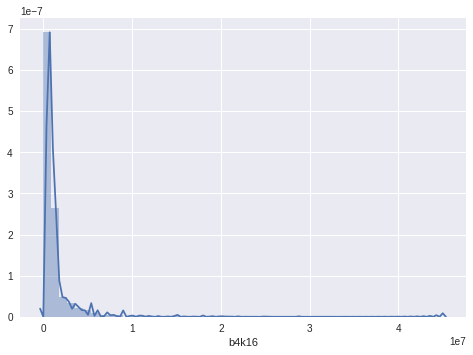

In [11]:
sns.distplot(data_train['b4k16']);

In [12]:
len(data_train[data_train[target] < 516000])/(1.0*len(data_train))

0.3442203009926353

Sebagian besar data (~34%) berada di rentang omset < Rp 516.000,00, sedangkan UMR Provinsi Bengkulu tahun 2006 adalah Rp 516.000,00 (Bappenas). Asumsi awal : Sebagian besar data adalah data perseorangan, karena omset < Rp 516.000,00 tidak dapat mencukupi lebih dari 1 orang dan data dengan tenaga kerja > 1 orang pasti omsetnya di atas UMR.

### b4k6 (Jenis usaha)

---


1. Los Koridor
2. Kaki Lima
3. Keliling
4. Pangkalan

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


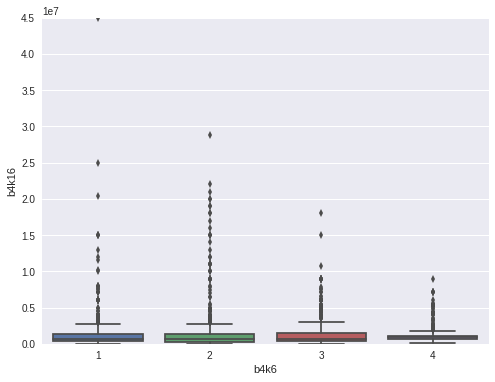

In [13]:
#box plot b4k6
var = 'b4k6'
data = pd.concat([data_train[target], data_train[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y=target, data=data)
fig.axis(ymin=0, ymax=45000000);

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


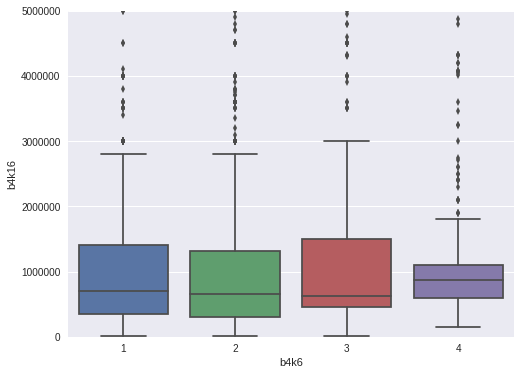

In [14]:
#box plot b4k6
var = 'b4k6'
data = pd.concat([data_train[target], data_train[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y=target, data=data)
fig.axis(ymin=0, ymax=5000000);

Banyak sekali outlier, tapi masih terlihat perbedaan tinggi pada masing masing IQR (inter quartile range). Data tetap dipakai

### b4k71 (bidang usaha)

In [15]:
data_train['b4k71'].value_counts()

G    1651
I    1185
H     182
O      82
D      15
P       6
K       1
J       1
Name: b4k71, dtype: int64

Tidak ada kategori X, semua bidang usaha pasti. Perdagangan dan Transportasi mendominasi bidang usaha.

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


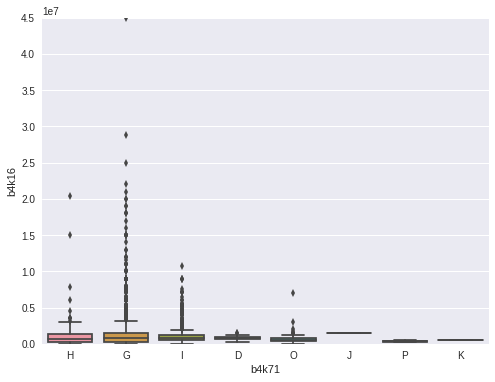

In [16]:
#box plot b4k6
var = 'b4k71'
data = pd.concat([data_train[target], data_train[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y=target, data=data)
fig.axis(ymin=0, ymax=45000000);

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


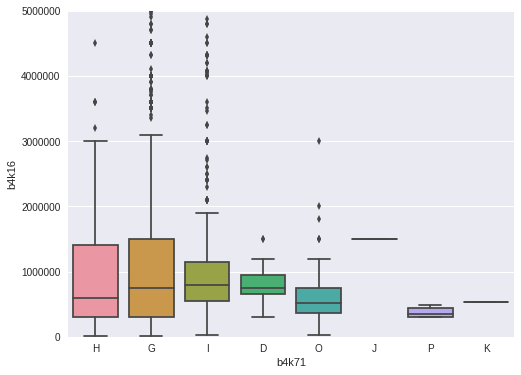

In [17]:
#box plot b4k6
var = 'b4k71'
data = pd.concat([data_train[target], data_train[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y=target, data=data)
fig.axis(ymin=0, ymax=5000000);

IQR berbeda beda, data tetap dipakai.

### buka, tutup, durasi

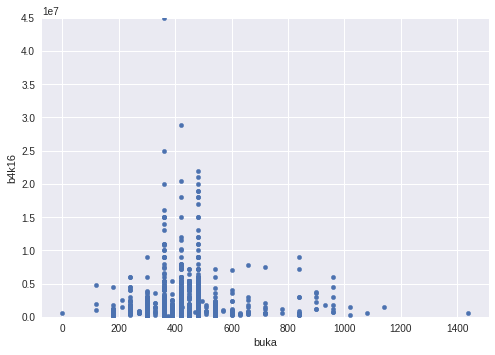

In [18]:
# buka
var = 'buka'
data = pd.concat([data_train[target], data_train[var]], axis=1)
data.plot.scatter(x=var, y=target, ylim=(0,45000000));

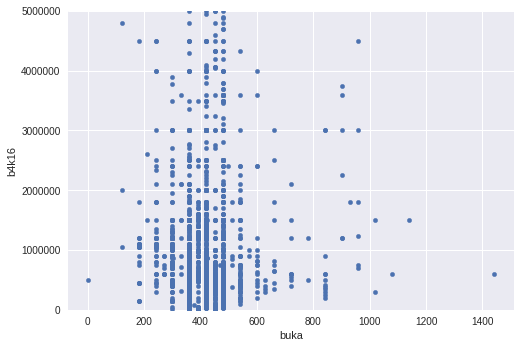

In [19]:
# buka
var = 'buka'
data = pd.concat([data_train[target], data_train[var]], axis=1)
data.plot.scatter(x=var, y=target, ylim=(0,5000000));

Tempat usaha yang memiliki waktu buka pada menit 300 - 500 memiliki rentang omset yang lebih tinggi.

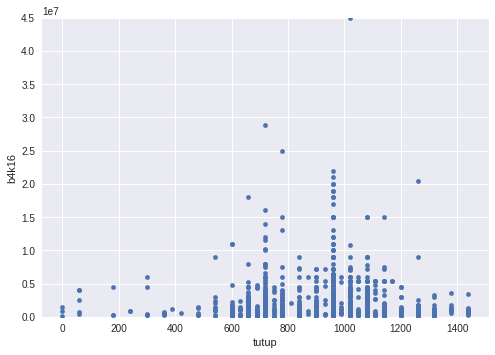

In [20]:
# tutup
var = 'tutup'
data = pd.concat([data_train[target], data_train[var]], axis=1)
data.plot.scatter(x=var, y=target, ylim=(0,45000000));

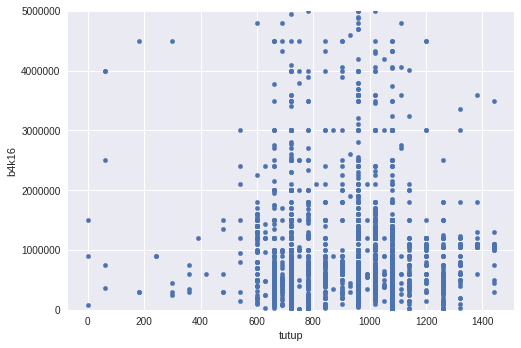

In [21]:
# tutup
var = 'tutup'
data = pd.concat([data_train[target], data_train[var]], axis=1)
data.plot.scatter(x=var, y=target, ylim=(0,5000000));

Tempat usaha yang memiliki waktu tutup pada menit 300 - 500 memiliki rentang omset yang lebih tinggi.

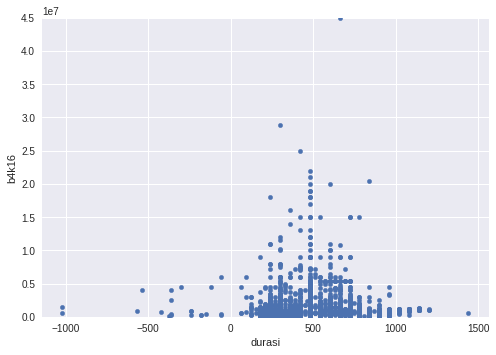

In [22]:
# durasi
var = 'durasi'
data = pd.concat([data_train[target], data_train[var]], axis=1)
data.plot.scatter(x=var, y=target, ylim=(0,45000000));

Ada data minus, berarti ada usaha yang buka malam tutup pagi.

Ubah menjadi durasi sesungguhnya.

In [0]:
data_train.loc[(data_train['durasi'] < 0), 'durasi'] += (24*60)

In [0]:
data_test.loc[(data_test['durasi'] < 0), 'durasi'] += (24*60)

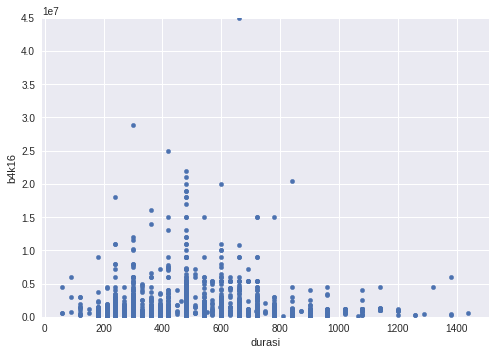

In [25]:
# durasi
var = 'durasi'
data = pd.concat([data_train[target], data_train[var]], axis=1)
data.plot.scatter(x=var, y=target, ylim=(0,45000000));

Tempat usaha yang memiliki durasi pada menit 300 - 600 memiliki rentang omset yang lebih tinggi.

### Jumlah tenaga kerja (b4k10, b4k11, b4k12)

---

Jumlah tenaga kerja laki-laki dan perempuan dapat disederhanakan menjadi rasio jumlah, karena yang dipengaruhi oleh tipe pekerjaan bukanlah banyaknya jumlah pegawai masing-masing jenis kelamin, tapi rasio jenis kelamin. Namun jumlah pegawai total tetap dipakai untuk membedakan ukuran usaha, misal 5-6 orang untuk toko sedang, dan ratusan orang untuk pabrik.

0 untuk perempuan dan 1 untuk laki-laki.

In [0]:
data_train['rasio_gender'] = data_train['b4k10'] / (data_train['b4k12'])
data_train = data_train.drop(['b4k10', 'b4k11'], axis = 1)

In [0]:
data_test['rasio_gender'] = data_test['b4k10'] / (data_test['b4k12'])
data_test = data_test.drop(['b4k10', 'b4k11'], axis = 1)

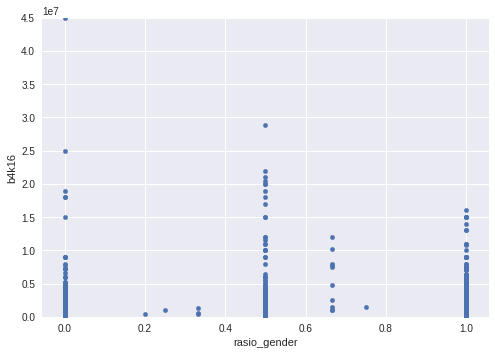

In [28]:
# rasio_gender
var = 'rasio_gender'
data = pd.concat([data_train[target], data_train[var]], axis=1)
data.plot.scatter(x=var, y=target, ylim=(0,45000000));

Terlihat bahwa sebagian besar usaha memiliki rasio 0, 1, dan 0.5.

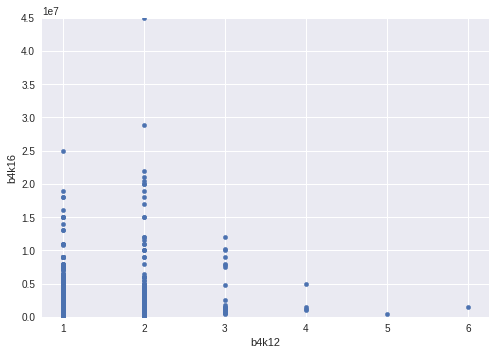

In [29]:
# total pegawai
var = 'b4k12'
data = pd.concat([data_train[target], data_train[var]], axis=1)
data.plot.scatter(x=var, y=target, ylim=(0,45000000));

### b4k13 (Aset tahun lalu)

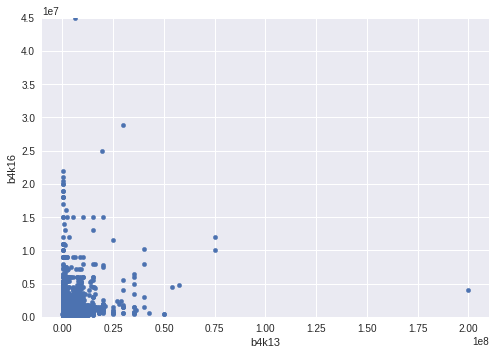

In [30]:
# Aset tahun lalu
var = 'b4k13'
data = pd.concat([data_train[target], data_train[var]], axis=1)
data.plot.scatter(x=var, y=target, ylim=(0,45000000));

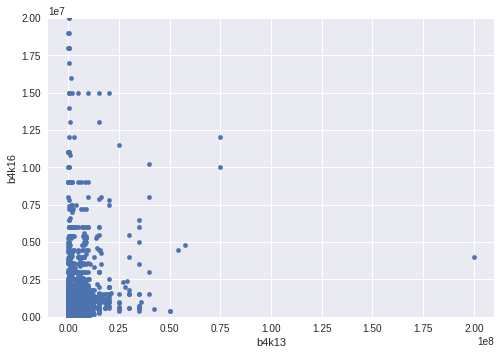

In [31]:
# Aset tahun lalu
var = 'b4k13'
data = pd.concat([data_train[target], data_train[var]], axis=1)
data.plot.scatter(x=var, y=target, ylim=(0,20000000));

## Outlier

---

Selama kita melakukan eksplorasi, ada 1 data yang sangat mencolok, yaitu data dengan nilai target Rp 45.000.000,00, yang mempunyai pegawai 2 dan rasio 0 (perempuan semua). Mari kita lihat lebih lengkap data tersebut.

In [32]:
data_train[data_train[target] == 45000000]

,iduniq,b4k6,b4k71,b4k12,b4k13,b4k16,b4k17,buka,tutup,durasi,rasio_gender
2855,1118,1,G,2,6000000,45000000,12,360,1020,660,0.000


Data ini jelas merupakan data outlier (Aset dan omset tahun lalu sangat jauh, fitur-fitur lain sama seperti kebanyakan data), sehingga kita dapat melakukan drop terhadap fitur ini.

In [0]:
data_train = data_train[data_train[target] < 45000000]

## Dummies

---

b4k6 dan b4k71

In [0]:
data_train = pd.get_dummies(data_train, columns = ['b4k6', 'b4k71'])
data_test = pd.get_dummies(data_test, columns = ['b4k6', 'b4k71'])

In [0]:
# Menyamakan dummy antara data train dan test
# Menyalin kolom di data train yang belum ada di data test, dan menghapus kolom di data test yang tidak ada di data train

# Get missing columns in the training test
missing_cols = set( data_train.columns ) - set( data_test.columns )
# Add a missing column in test set with default value equal to 0
for c in missing_cols:
    data_test[c] = 0
# Ensure the order of column in the test set is in the same order than in train set
data_test = data_test[data_train.columns]
# Delete target column in data test
data_test = data_test.drop([target], axis = 1)

## Drop ID unik

In [0]:
data_train = data_train.drop('iduniq', axis = 1)
data_test = data_test.drop('iduniq', axis = 1)

##Pemisahan berdasarkan jumlah orang

In [37]:
len(data_train[data_train['b4k12'] == 1]) / (1.0 * len(data_train))

0.92152466367713

In [38]:
len(data_test[data_test['b4k12'] == 1]) / (1.0 * len(data_test))

0.9365994236311239

Jumlah usaha yang hanya terdapat 1 orang sangat banyak (~92%) sehingga kita perlu memisahkan data train berdasarkan jumlah orang

In [0]:
data_train_tunggal = data_train[data_train.b4k12 == 1]
data_train_jamak = data_train[data_train.b4k12 > 1]

## Heatmap

### Tunggal

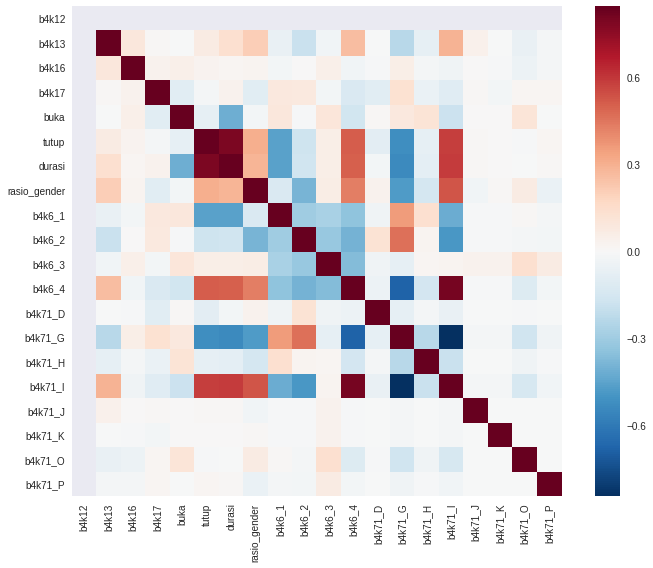

In [40]:
corrmat = data_train_tunggal.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

### Jamak

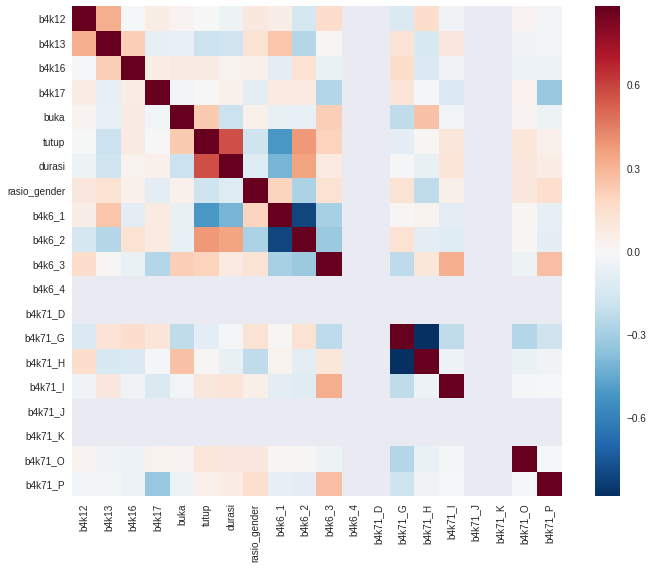

In [41]:
corrmat = data_train_jamak.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

### Semua

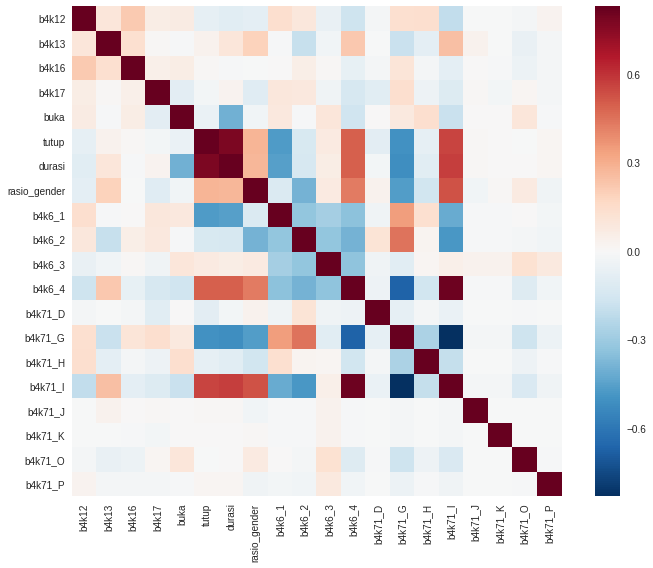

In [42]:
corrmat = data_train.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

## Pemilihan model

### Semua

In [0]:
train_x = data_train.drop('b4k16', axis = 1)
train_y = data_train[target]

In [0]:
#bikin kategori baru
train_x['is_one'] = 0
train_x.loc[train_x['b4k12'] == 1,'is_one'] = 1

In [45]:
# MLP
from sklearn.neural_network import MLPRegressor as mlp
mdl = mlp()
mdl.fit(train_x, train_y)

MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [46]:
data_test.head()

,b4k12,b4k13,b4k17,buka,tutup,durasi,rasio_gender,b4k6_1,b4k6_2,b4k6_3,b4k6_4,b4k71_D,b4k71_G,b4k71_H,b4k71_I,b4k71_J,b4k71_K,b4k71_O,b4k71_P
0,1,7200000,8,480.000,1020,540.000,1.000,0,0,1,0,0,1,0,0,0,0,0,0
1,1,3000000,6,420.000,1020,600.000,1.000,0,0,1,0,0,1,0,0,0,0,0,0
2,1,7500000,10,780.000,1020,240.000,1.000,0,0,1,0,0,1,0,0,0,0,0,0
3,1,7200000,6,960.000,1380,420.000,0.000,1,0,0,0,0,0,1,0,0,0,0,0
4,1,9000000,6,1020.000,1320,300.000,0.000,1,0,0,0,0,0,1,0,0,0,0,0


In [0]:
import copy
test = copy.copy(data_test)
test['is_one'] = 0
test.loc[test['b4k12'] == 1,'is_one'] = 1

In [48]:
test.head()

,b4k12,b4k13,b4k17,buka,tutup,durasi,rasio_gender,b4k6_1,b4k6_2,b4k6_3,b4k6_4,b4k71_D,b4k71_G,b4k71_H,b4k71_I,b4k71_J,b4k71_K,b4k71_O,b4k71_P,is_one
0,1,7200000,8,480.000,1020,540.000,1.000,0,0,1,0,0,1,0,0,0,0,0,0,1
1,1,3000000,6,420.000,1020,600.000,1.000,0,0,1,0,0,1,0,0,0,0,0,0,1
2,1,7500000,10,780.000,1020,240.000,1.000,0,0,1,0,0,1,0,0,0,0,0,0,1
3,1,7200000,6,960.000,1380,420.000,0.000,1,0,0,0,0,0,1,0,0,0,0,0,1
4,1,9000000,6,1020.000,1320,300.000,0.000,1,0,0,0,0,0,1,0,0,0,0,0,1


In [0]:
y = mdl.predict(test)

In [50]:
submit = pd.DataFrame(y, columns = ['b4k16'])
data_test = pd.read_csv('/content/data/test.csv')
submission = pd.DataFrame({ 'iduniq': data_test['iduniq'], 'b4k16': submit['b4k16']
                             })

submission.head()

,b4k16,iduniq
0,763620.723,887
1,318792.025,3600
2,795448.426,1021
3,764052.066,1698
4,954640.699,1986


In [0]:
from google.colab import files

submission.to_csv('yo.csv', index = False)
files.download('yo.csv')

 ## KEN

In [0]:
from sklearn.linear_model import LinearRegression
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import SGDRegressor

from math import *

In [53]:
train = data_train_tunggal.drop(target,axis=1)
train_y = data_train_tunggal[target]

seed=2018
cv_scores=[]
kfold = KFold(n_splits=10, random_state=seed)

regr = LinearRegression(fit_intercept=True, normalize=True)
#regr = RandomForestRegressor()

 
# fit the model with training set
scores = cross_val_score(regr, train, train_y, cv=kfold, scoring='neg_mean_squared_error')

print (sqrt(-scores.mean()))

1686641.6934097447


In [0]:
train = data_train_jamak.drop(target,axis=1)
train_y = data_train_jamak[target]

seed=2018
cv_scores=[]
kfold = KFold(n_splits=10, random_state=seed)

regr = LinearRegression(fit_intercept=True, normalize=True)
#regr = RandomForestRegressor()

 
# fit the model with training set
scores = cross_val_score(regr, train, train_y, cv=kfold, scoring='neg_mean_squared_error')

print (sqrt(-scores.mean()))

In [54]:
regr = RandomForestRegressor()

 
# fit the model with training set
scores = cross_val_score(regr, train, train_y, cv=kfold, scoring='neg_mean_squared_error')

print (sqrt(-scores.mean()))

2047841.7589717696


In [55]:
from sklearn.linear_model import SGDRegressor

regr = SGDRegressor()

 
# fit the model with training set
scores = cross_val_score(regr, train, train_y, cv=kfold, scoring='neg_mean_squared_error')

print (sqrt(-scores.mean()))

5.1567275193540436e+22


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/usr/local/lib/python3.6/dist-packages/skl

In [56]:
from sklearn.linear_model import Lasso

regr1 = Lasso()

 
# fit the model with training set
scores = cross_val_score(regr, train, train_y, cv=kfold, scoring='neg_mean_squared_error')

print (sqrt(-scores.mean()))


2.0553284051538375e+22


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/usr/local/lib/python3.6/dist-packages/skl

In [57]:
from sklearn.linear_model import ElasticNet

regr1 = ElasticNet()

 
# fit the model with training set
scores = cross_val_score(regr1, train, train_y, cv=kfold, scoring='neg_mean_squared_error')

print (sqrt(-scores.mean()))

1672089.0254129882


In [58]:
from sklearn.ensemble import AdaBoostRegressor


regr1 = AdaBoostRegressor()

 
# fit the model with training set
scores = cross_val_score(regr1, train, train_y, cv=kfold, scoring='neg_mean_squared_error')

print (sqrt(-scores.mean()))

2215782.0209435974


In [59]:
from sklearn.ensemble import BaggingRegressor


regr1 = BaggingRegressor()

 
# fit the model with training set
scores = cross_val_score(regr1, train, train_y, cv=kfold, scoring='neg_mean_squared_error')

print (sqrt(-scores.mean()))

2146386.4226680966


In [60]:
from sklearn.linear_model import Ridge

regr1 = Ridge()

 
# fit the model with training set
scores = cross_val_score(regr1, train, train_y, cv=kfold, scoring='neg_mean_squared_error')

print (sqrt(-scores.mean()))

1686506.7107413947


In [0]:
from sklearn.svm import SVR

regr1 = SVR(kernel='linear')

 
# fit the model with training set
scores = cross_val_score(regr1, train, train_y, cv=kfold, scoring='neg_mean_squared_error')

print (sqrt(-scores.mean()))
